In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [5]:
torch.manual_seed(42)

In [6]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device : {device}")

Using device : cuda


In [7]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/fmnist_small.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


In [8]:
df.shape

(6000, 785)

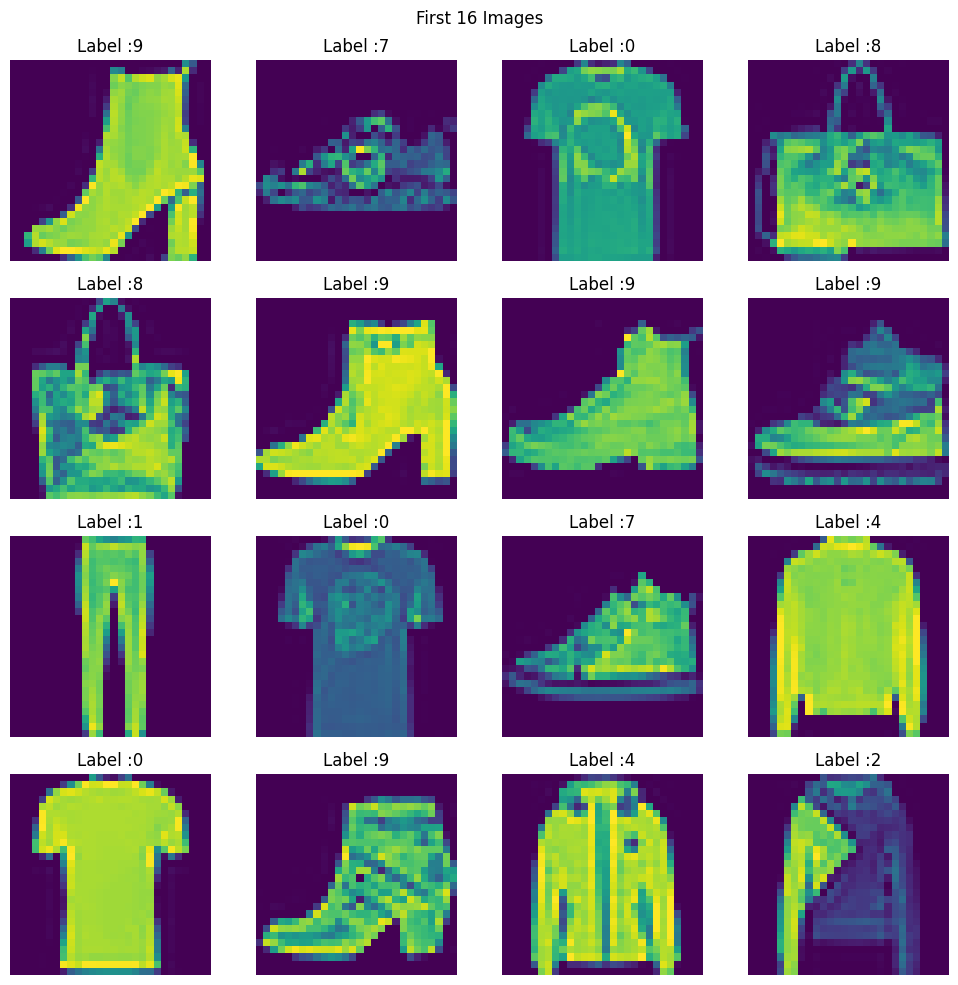

In [9]:
fig,axes = plt.subplots(4,4,figsize=(10,10))
fig.suptitle("First 16 Images")

for i,ax in enumerate(axes.flat):
  image=df.iloc[i,1:].values.reshape(28,28)
  ax.imshow(image)
  ax.axis('off')
  ax.set_title(f"Label :{df.iloc[i,0]}")

plt.tight_layout()
plt.show()

In [10]:
X=df.iloc[:,1:].values
y=df.iloc[:,0].values

In [11]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [12]:
from torchvision.transforms import transforms

custom_transforms=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [13]:
pip install torchvision

In [14]:
from PIL import Image
import numpy as np


class CustomDataset(Dataset):
  def __init__(self,features,labels,transform):
    self.features=features
    self.labels=labels
    self.transform=transform

  def __len__(self):
    return len(self.features)

  def __getitem__(self,index):
    #resize to (28,28)
    image=self.features[index].reshape(28,28)
    #change datatype to unit8
    image=image.astype(np.uint8)
    # change black and white to color (H,W,C) -> (C,H,W)
    image=np.stack([image]*3,axis=-1)

    #convert array to PIL image
    image=Image.fromarray(image)

    #apply transforms
    image=self.transform(image)

    return image,torch.tensor(self.labels[index],dtype=torch.long)


In [15]:
train_dataset=CustomDataset(X_train,y_train,custom_transforms)
test_dataset=CustomDataset(X_test,y_test,custom_transforms)

In [16]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)

In [17]:
import torchvision.models as models
vgg16=models.vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
for param in vgg16.parameters():
  param.requires_grad=False

In [20]:
vgg16.classifier=nn.Sequential(
    nn.Linear(25088,1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024,512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512,10)
)

In [21]:
vgg16=vgg16.to(device)

In [22]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [23]:
learning_rate=0.0001
epochs=10

In [24]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(vgg16.classifier.parameters(),lr=learning_rate)

In [26]:
# training loop

for epoch in range(epochs):
  total_epoch_loss=0

  for batch_features,batch_labels in train_loader:
    # move data to gpu

    batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)

    # forward pass
    outputs=vgg16(batch_features)

    # calculate loss
    loss=criterion(outputs,batch_labels)

    # backpass

    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss+=loss.item()

    break

  print(f"Epoch : {epoch+1}/{epochs} Loss : {total_epoch_loss/len(train_loader)}")


Epoch : 1/10 Loss : 0.0001777308185895284
Epoch : 2/10 Loss : 0.00028851620852947234
Epoch : 3/10 Loss : 6.875195230046908e-05
Epoch : 4/10 Loss : 0.0004109993577003479
Epoch : 5/10 Loss : 0.00015310501058896382
Epoch : 6/10 Loss : 0.00024066152671972912
Epoch : 7/10 Loss : 0.0002959183355172475
Epoch : 8/10 Loss : 0.000448144127925237
Epoch : 9/10 Loss : 0.00042099843422571816
Epoch : 10/10 Loss : 0.00040733282764752706


In [28]:
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [32]:
total=0
correct=0

with torch.no_grad():
  for batch_features, batch_labels in train_loader:
    batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)

    outputs=vgg16(batch_features)

    _,predicred=torch.max(outputs,1)

    total+=batch_labels.shape[0]

    correct+=(predicred==batch_labels).sum().item()

print(correct/total)

0.9970833333333333


In [31]:
total=0
correct=0

with torch.no_grad():
  for batch_features, batch_labels in test_loader:
    batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)

    outputs=vgg16(batch_features)

    _,predicred=torch.max(outputs,1)

    total+=batch_labels.shape[0]

    correct+=(predicred==batch_labels).sum().item()

print(correct/total)

0.8925
